<a href="https://colab.research.google.com/github/gpdsec/Transfer-Learning/blob/main/FoodClassification101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Checking GPU**

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f06fd4b7-5694-0e49-08a2-f59b30775b0f)


## **1. Importing Libraries**

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Softmax, Input, GlobalAveragePooling2D
from tensorflow.keras import mixed_precision, Sequential, layers, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [46]:
%reload_ext tensorboard

## **2. Loading Data from TFDS**

In [6]:
(train_ds, test_ds), info = tfds.load('food101',
                                      split=['train', 'validation'],
                                      with_info=True,
                                      as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteDTPYKQ/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteDTPYKQ/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
info

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

In [8]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
classLabels = info.features["label"].names

In [10]:
classLabels[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [11]:
for image, label in train_ds.take(1):
  break

image dtype <dtype: 'uint8'>
raw image shape (512, 512, 3)
type <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]

 [[228 254 253]
  [226 255 253]
  [223 255 252]
  ...
  [164 159 155]
  [145 141 138]
  [128 127 125]]

 ...

 [[ 66 112 164]
  [ 67 113 163]
  [ 55  99 148]
  ...
  [  5  14  23]
  [  9  18  27]
  [  8  17  26]]

 [[ 76 123 177]
  [ 75 122 176]
  [ 70 116 168]
  ...
  [  5  14  23]
  [  9  18  25]
  [  7  16  23]]

 [[ 80 129 185]
  [ 71 121 174]
  [ 74 121 175]
  ...
  [  7  16  25]
  [ 11  20  27]
  [ 10  19  26]]], shape=(512, 512, 3), dtype=uint8)
image


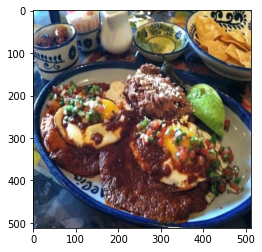

In [12]:
print(f"image dtype {image.dtype}")
print(f"raw image shape {image.shape}")
print(f"type {type(image)}")
print(image)
print("image")
plt.imshow(image)

## **3.Helpfull functions**

In [13]:
def pad_image(img, label):
  """ takes 3D array as input pad it square 
  to its maximum dimenshions
  zero to right or botome """
  sh = tf.shape(img, out_type=tf.dtypes.int32, name=None)
  (x,y,z) = tuple(sh)
  x = int(x)
  y = int(y)

  max_side = max(x,y)
  pad_width =tf.constant([(0,(max_side-x)),(0,(max_side-y)),(0,0)])
  image = tf.pad(img,pad_width, 'constant', constant_values=0)
  image = tf.image.resize(image, [224, 224])
  image = tf.cast(image, tf.float32)

  return image, label

# Data augmentation layer
augmentation=Sequential([
                         #tf.keras.layers.InputLayer(),
                         layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                         layers.experimental.preprocessing.RandomRotation(0.2),])

# augment function
def augment(image_batch, label_batch):
  #image_batch = preprocessing.Rescaling(1./255)(image_batch)
  image_batch = augmentation(image_batch, training=True)
  
  return image_batch, label_batch

# Map Funtion
def map_funct1(image, label):
  
  image = tf.image.resize(image, [224, 224])
  image = tf.cast(image, tf.float32)
  return image, label

def map_funct2(image, label):
  
  image = tf.image.resize_with_pad(image, 224, 224)
  image = tf.cast(image, tf.float32)
  return image, label

In [23]:
def dataset(train_ds = train_ds, test_ds=test_ds, batch_size =32, augmetation= False, padding = False):
  
  if padding:
    map_funct = map_funct2
  else:
    map_funct = map_funct1
  

  # Train DataSet
  train_dataset = train_ds.map(map_func=map_funct, num_parallel_calls=tf.data.AUTOTUNE)
  train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
  if augmetation:
    train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

  # Test Dataset
  test_dataset = test_ds.map(map_func=map_funct, num_parallel_calls=tf.data.AUTOTUNE)
  test_dataset = test_dataset.shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

  return train_dataset, test_dataset


## **4. Data Pipeline**

In [16]:
# Important variables
batch_size = 32
shape = (224, 224, 3)

In [24]:
train_dataset, test_dataset = dataset(batch_size= batch_size)


image shape (224, 224, 3)
image dtype <dtype: 'float32'>
image [[[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 ...

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]]


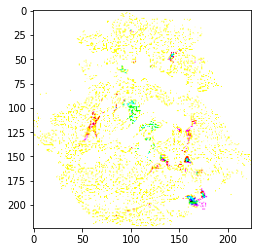

In [25]:
for images, labels in train_dataset.take(1):
  for image in images:
    print(f"image shape {image.shape}")
    print(f"image dtype {image.dtype}")
    print(f"image {image}")
    plt.imshow(image)
    break

## **5. Setting Callback**

In [26]:
es = EarlyStopping(monitor='val_loss', patience=12, mode='min')
filepath='/content/drive/MyDrive/model/food101.h5'
md = ModelCheckpoint(filepath, monitor='val_loss', 
verbose=1, save_best_only=True, save_weights_only=False, mode='min')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
lr = 0.001
def scheduler(epoch):
  lr2 = lr
  if epoch < 10:
    lr2 = lr2/10
  return lr2

lrs = LearningRateScheduler(scheduler)

sgd = SGD(learning_rate=0.001)
adam = Adam(learning_rate=lr)

## **6. Buildind Model**

In [18]:
# seting up base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet")
base_model.trainable = False

16711680/16705208 [==============================] - 0s 0us/step


In [19]:
# Turn on mixed precision training
mixed_precision.set_global_policy(policy="mixed_float16")
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


<Policy "mixed_float16">

In [27]:

# building model architecture

input = Input(shape=shape, name="input")
#x = preprocessing.Rescaling(1./255)(i)
#x = tf.keras.applications.resnet.preprocess_input(input)
x = base_model(input, training=False)
x = GlobalAveragePooling2D(name="pooling")(x)
x = Dense(101, name="output_layer")(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="predictions")(x) 
model = Model(input, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling (GlobalAveragePoolin (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
_________________________________________________________________
predictions (Activation)     (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [28]:
rm -rf ./logs

In [29]:
model_history = model.fit(train_dataset,
                            epochs=4,  
                            verbose=1, 
                            callbacks=[tb, md, es],
                            steps_per_epoch=len(train_dataset), 
                            validation_data=test_dataset, 
                            validation_steps=(0.2*len(test_dataset)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/4
2368/2368 [==============================] - 262s 95ms/step - loss: 1.8218 - accuracy: 0.5565 - val_loss: 1.2429 - val_accuracy: 0.6709

Epoch 00001: val_loss improved from inf to 1.24290, saving model to /content/drive/MyDrive/model/food101.h5
Epoch 2/4
2368/2368 [==============================] - 218s 91ms/step - loss: 1.2951 - accuracy: 0.6658 - val_loss: 1.1420 - val_accuracy: 0.6930

Epoch 00002: val_loss improved from 1.24290 to 1.14203, saving model to /content/drive/MyDrive/model/food101.h5
Epoch 3/4
2368/2368 [==============================] - 195s 81ms/step - loss: 1.1456 - accuracy: 0.7016 - val_loss: 1.1067 - val_accuracy: 0.7025

Epoch 00003: val_loss improved from 1.14203 to 1.10670, saving model to /content/drive/MyDrive/model/food101.h5
Epoch 4/4
2368/2368 [==============================] - 194s 81ms/step - loss: 1.0474 - accuracy: 0.7261 - val_loss: 1.0920 - val_accuracy: 0.7041

Epoch 00004: val_loss improved from 1.10670 to 1.09199, saving model to /content

## **7. Fine Tuning Stage I**

In [30]:
model = tf.keras.models.load_model('/content/drive/MyDrive/model/food101.h5')

In [31]:
for layer in model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">
predictions True float32 <Policy "float32">


###### **CallBack II**

In [33]:
es = EarlyStopping(monitor='val_loss', patience=3)
filepathft='/content/drive/MyDrive/model/FT_food101.h5'
md = ModelCheckpoint(filepathft, monitor='val_loss', 
                     verbose=1, save_best_only=True, save_weights_only=False, mode='min')


lr =  0.0001
def scheduler(epoch):
  lr2 =  lr
  if epoch < 2:
    return lr2
  else:
    for i in range(epoch-1):
      lr2 = lr2 - 0.000001
    return lr2
# Creating learning rate reduction callback
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, 
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

lrs = LearningRateScheduler(scheduler)
log_dir = "logsFT/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
sgd = SGD(learning_rate=0.00001)
adam = Adam(learning_rate=lr) 


In [35]:
#base_model.trainable = True
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling (GlobalAveragePoolin (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
_________________________________________________________________
predictions (Activation)     (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [36]:
rm -rf ./logsFT

In [38]:
model_history = model.fit(train_dataset,
                            epochs=7,  
                            verbose=1, 
                            callbacks=[tb, es, md, rlr],
                            steps_per_epoch=len(train_dataset), 
                            validation_data=test_dataset, 
                            validation_steps=(0.2*len(test_dataset)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/3
2368/2368 [==============================] - 843s 349ms/step - loss: 0.8837 - accuracy: 0.7618 - val_loss: 0.8658 - val_accuracy: 0.7587

Epoch 00001: val_loss improved from inf to 0.86580, saving model to /content/drive/MyDrive/model/FT_food101.h5
Epoch 2/3
2368/2368 [==============================] - 815s 343ms/step - loss: 0.5370 - accuracy: 0.8512 - val_loss: 0.8735 - val_accuracy: 0.7698

Epoch 00002: val_loss did not improve from 0.86580
Epoch 3/3
2368/2368 [==============================] - 816s 344ms/step - loss: 0.2925 - accuracy: 0.9183 - val_loss: 0.9681 - val_accuracy: 0.7712

Epoch 00003: val_loss did not improve from 0.86580

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.


In [48]:
# loading best model
model = tf.keras.models.load_model(filepathft)
# model evaluating

pred = model.evaluate(test_dataset)

790/790 [==============================] - 76s 88ms/step - loss: 0.8661 - accuracy: 0.7595


In [47]:
%tensorboard --logdir logsFT/fit

Reusing TensorBoard on port 6006 (pid 2900), started 0:09:27 ago. (Use '!kill 2900' to kill it.)

<IPython.core.display.Javascript object>

## **8. Fine Tuning Stage II**

###### **CallBack III**

In [49]:

es = EarlyStopping(monitor='val_loss', patience=3)
filepathft='/content/drive/MyDrive/model/FT2_food101.h5'
md = ModelCheckpoint(filepathft, monitor='val_loss', 
                     verbose=1, save_best_only=True, save_weights_only=False, mode='min')


lr =  0.0001
def scheduler(epoch):
  lr2 =  lr
  if epoch < 2:
    return lr2
  else:
    for i in range(epoch-1):
      lr2 = lr2 - 0.000001
    return lr2
# Creating learning rate reduction callback
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, 
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

lrs = LearningRateScheduler(scheduler)
log_dir = "logsFT/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
sgd = SGD(learning_rate=0.00001)
adam = Adam(learning_rate=lr) 


In [50]:
train_dataset, test_dataset = dataset(batch_size= batch_size, augmetation=True, padding=True)

In [51]:
model_history = model.fit(train_dataset,
                            epochs=7,  
                            verbose=1, 
                            callbacks=[tb, es, md, rlr],
                            steps_per_epoch=len(train_dataset), 
                            validation_data=test_dataset, 
                            validation_steps=(0.2*len(test_dataset)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/7
2368/2368 [==============================] - 898s 372ms/step - loss: 1.0006 - accuracy: 0.7263 - val_loss: 0.8396 - val_accuracy: 0.7710

Epoch 00001: val_loss improved from inf to 0.83962, saving model to /content/drive/MyDrive/model/FT2_food101.h5
Epoch 2/7
2368/2368 [==============================] - 888s 371ms/step - loss: 0.7815 - accuracy: 0.7811 - val_loss: 0.8558 - val_accuracy: 0.7731

Epoch 00002: val_loss did not improve from 0.83962
Epoch 3/7
2368/2368 [==============================] - 878s 370ms/step - loss: 0.6374 - accuracy: 0.8176 - val_loss: 0.8794 - val_accuracy: 0.7617

Epoch 00003: val_loss did not improve from 0.83962

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/7
2368/2368 [==============================] - 879s 370ms/step - loss: 0.3977 - accuracy: 0.8863 - val_loss: 0.8695 - val_accuracy: 0.7749

Epoch 00004: val_loss did not improve from 0.83962


In [52]:
path='/content/drive/MyDrive/model/FT2_food101.h5'
model.save(path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tf.keras.models.load_model(path)

In [53]:
pred = model.evaluate(test_dataset)

790/790 [==============================] - 68s 83ms/step - loss: 0.8801 - accuracy: 0.7809
